In [1]:
import os
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from trustee import ClassificationTrustee
from trustee.report.trust import TrustReport

plt.rcParams['font.family'] = 'sans-serif'

In [ ]:
# Dataset folders
# dataset_list = ['A', 'B1', 'B2', 'C', 'D']
dataset_list = ['A']

current_dir = os.getcwd()
base_path = '' + current_dir + '/test_data'

# Quality labels to predict
quality_labels = ['q144p', 'q240p', 'q360p', 'q480p', 'q720p', 'q1080p', 'q1440p', 'q2160p']

# Collect all merged CSVs
all_dfs = []
print("Loading CSV files...")
for dataset in tqdm(dataset_list, desc="Datasets"):
    path_pattern = os.path.join(base_path + dataset, '*.csv')
    print(f"Searching in: {path_pattern}")
    for file_path in glob(path_pattern):
        try:
            df = pd.read_csv(file_path, dtype=str)
            all_dfs.append(df)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

Loading CSV files...


Datasets:   0%|                                           | 0/1 [00:00<?, ?it/s]

Searching in: /Users/Bryce/CS293N/293N-YT-ABR-Prediction/test_dataA/*.csv


In [ ]:
# Combine all data
print("Combining CSVs into one DataFrame...")
data = pd.concat(all_dfs, ignore_index=True)
print(f"Total rows loaded: {len(data)}")

In [ ]:
print(data.columns)

In [6]:
# Drop rows with missing target values
# quality_to_index = {q: i for i, q in enumerate(quality_labels)}

df_numeric = data[quality_labels].applymap(lambda x: pd.to_numeric(x, errors='coerce'))
df_numeric = df_numeric[(df_numeric > 0).any(axis=1)]

data = data.loc[df_numeric.index]

# data['PlaybackQuality'] = df_numeric.idxmax(axis=1).map(quality_to_index)
data['PlaybackQuality'] = df_numeric.idxmax(axis=1)

print("Filtering out rows with no quality label...")
data = data.dropna(subset=['PlaybackQuality'])

Filtering out rows with no quality label...


In [7]:
data

,RelativeTime,PacketsSent,PacketsReceived,BytesSent,BytesReceived,IPSrc0,IPDst0,Protocol0,PacketsSent0,PacketsReceived0,...,q360p,q480p,q720p,q1080p,q1440p,q2160p,BufferHealth,BufferProgress,BufferValid,PlaybackQuality
61,6.099999999999994,24,45,2554,61722,192.168.1.190,173.194.191.199,0,0,0,...,0,1,0,0,0,0,8.755999885559081,0.0102126102014195,true,q480p
62,6.199999999999994,39,77,3185,107184,192.168.1.190,173.194.191.199,0,0,0,...,0,1,0,0,0,0,8.654999814987182,0.0102126102014195,true,q480p
63,6.299999999999994,35,68,3639,93308,192.168.1.190,173.194.191.199,0,0,0,...,0,1,0,0,0,0,8.554999910354613,0.0102126102014195,true,q480p
64,6.399999999999993,10,17,1872,17093,192.168.1.190,173.194.191.199,0,0,0,...,0,1,0,0,0,0,10.592562078201292,0.0124332496756467,true,q480p
65,6.499999999999993,24,39,2510,48130,192.168.1.190,173.194.191.199,0,0,0,...,0,1,0,0,0,0,10.493562101089475,0.0124332496756467,true,q480p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091466,599.6000000000678,0,0,0,0,192.168.1.190,173.194.53.200,0,0,0,...,0,0,1,0,0,0,44.99557384169009,1.0,true,q720p
2091467,599.7000000000678,0,0,0,0,192.168.1.190,173.194.53.200,0,0,0,...,0,0,1,0,0,0,44.898573958038355,1.0,true,q720p
2091468,599.8000000000678,0,0,0,0,192.168.1.190,173.194.53.200,0,0,0,...,0,0,1,0,0,0,44.80157383596804,1.0,true,q720p
2091469,599.9000000000678,0,0,0,0,192.168.1.190,173.194.53.200,0,0,0,...,0,0,1,0,0,0,44.69951293133545,1.0,true,q720p


In [8]:
# Wrap in tqdm for progress bar
for col in tqdm(data.columns, desc="Converting columns to numeric"):
    data[col] = pd.to_numeric(data[col], errors='ignore')
print(data)

Converting columns to numeric: 100%|██████████| 208/208 [11:29<00:00,  3.31s/it]


         RelativeTime  PacketsSent  PacketsReceived  BytesSent  BytesReceived  \
61                6.1           24               45       2554          61722   
62                6.2           39               77       3185         107184   
63                6.3           35               68       3639          93308   
64                6.4           10               17       1872          17093   
65                6.5           24               39       2510          48130   
...               ...          ...              ...        ...            ...   
2091466         599.6            0                0          0              0   
2091467         599.7            0                0          0              0   
2091468         599.8            0                0          0              0   
2091469         599.9            0                0          0              0   
2091470         600.0            4                4        264            327   

                 IPSrc0    

In [9]:
le = LabelEncoder()
data['PlaybackQuality'] = le.fit_transform(data['PlaybackQuality'])

In [10]:
# Drop original quality columns
data = data.drop(columns=quality_labels)

# Drop any remaining non-numeric columns
data = data.select_dtypes(include=['number', 'bool'])

# Drop time columns to prevent shortcut learning
data = data.drop(columns=['StartTime', 'EpochTime'])

# Drop rows with NaN
data = data.dropna()

print(data.head())

    RelativeTime  PacketsSent  PacketsReceived  BytesSent  BytesReceived  \
61           6.1           24               45       2554          61722   
62           6.2           39               77       3185         107184   
63           6.3           35               68       3639          93308   
64           6.4           10               17       1872          17093   
65           6.5           24               39       2510          48130   

    PacketsSent0  PacketsReceived0  BytesSent0  BytesReceived0  PacketsSent1  \
61             0                 0           0               0            24   
62             0                 0           0               0            39   
63             0                 0           0               0            34   
64             0                 0           0               0             7   
65             0                 0           0               0            20   

    ...  Buffering  Paused  Playing  CollectData  PlaybackProg

In [11]:
# Encode labels
# le = LabelEncoder()
# data['PlaybackQuality'] = le.fit_transform(data['PlaybackQuality'])

# Separate features and labels
X = data.drop(columns=['PlaybackQuality'])
y = data['PlaybackQuality']

In [12]:
print(y)
print(X)

61         4
62         4
63         4
64         4
65         4
          ..
2091466    5
2091467    5
2091468    5
2091469    5
2091470    5
Name: PlaybackQuality, Length: 2032988, dtype: int64
         RelativeTime  PacketsSent  PacketsReceived  BytesSent  BytesReceived  \
61                6.1           24               45       2554          61722   
62                6.2           39               77       3185         107184   
63                6.3           35               68       3639          93308   
64                6.4           10               17       1872          17093   
65                6.5           24               39       2510          48130   
...               ...          ...              ...        ...            ...   
2091466         599.6            0                0          0              0   
2091467         599.7            0                0          0              0   
2091468         599.8            0                0          0             

In [13]:
# Split
print("Splitting into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
print("Training Random Forest Classifier...")
clf = RandomForestClassifier(n_estimators=10, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
print("\nEvaluating model...")
y_pred = clf.predict(X_test)

Splitting into training and test sets...
Training Random Forest Classifier...


Training: 100%|███████████████████████████████████| 1/1 [00:38<00:00, 38.66s/it]



Evaluating model...


Classification Report:
              precision    recall  f1-score   support

       q144p       0.66      0.68      0.67     43584
       q240p       0.67      0.68      0.67     39614
       q360p       0.65      0.64      0.65     44634
       q480p       0.80      0.77      0.78     81198
       q720p       0.91      0.92      0.92    124440
      q1080p       0.93      0.95      0.94     73128

    accuracy                           0.81    406598
   macro avg       0.77      0.77      0.77    406598
weighted avg       0.81      0.81      0.81    406598



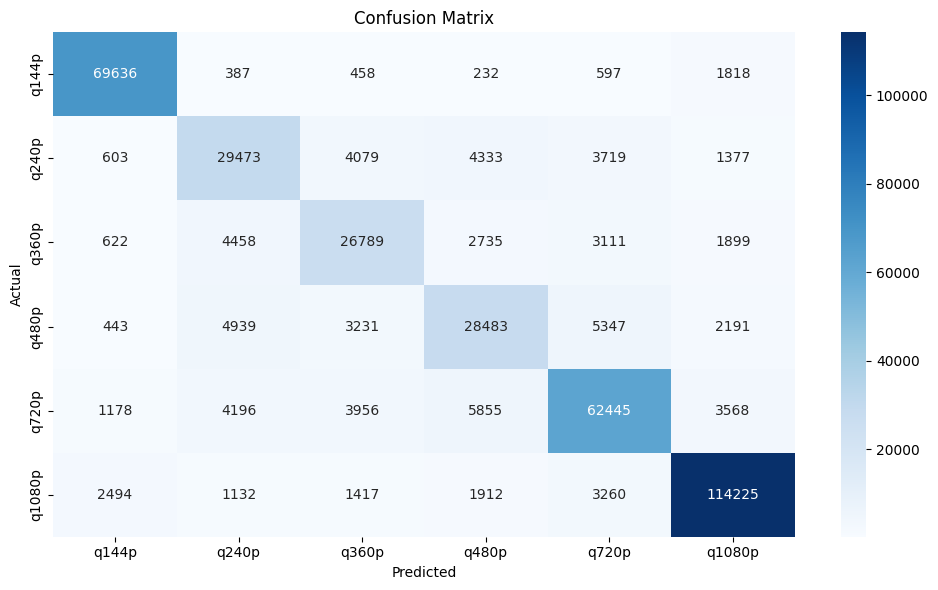

In [23]:
# Convert the integer labels back to string labels
y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred)

# Define desired order of quality labels
ordered_labels = ['q144p', 'q240p', 'q360p', 'q480p', 'q720p', 'q1080p']

# Classification report with string labels
print("Classification Report:")
print(classification_report(y_test_str, y_pred_str, labels=ordered_labels, target_names=ordered_labels))

# Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=ordered_labels, yticklabels=ordered_labels, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# TRUSTEE

In [24]:
importances = clf.feature_importances_
feat_names = X.columns

for name, imp in sorted(zip(feat_names, importances), key=lambda x: -x[1])[:20]:
    print(f"{name}: {imp:.4f}")

BufferHealth: 0.3447
RelativeTime: 0.1873
PlaybackProgress: 0.1344
BufferProgress: 0.1107
Length: 0.1107
BytesSent: 0.0156
PacketsSent0: 0.0132
BytesSent0: 0.0128
PacketsReceived0: 0.0111
PacketsSent: 0.0108
BytesReceived: 0.0106
PacketsReceived: 0.0101
BytesReceived0: 0.0095
BytesReceived25: 0.0024
PacketsReceived25: 0.0017
BytesReceived1: 0.0007
BytesSent1: 0.0007
BytesSent25: 0.0006
PacketsReceived1: 0.0006
PacketsSent1: 0.0005


In [ ]:
trustee = ClassificationTrustee(expert=clf)
trustee.fit(X_train, y_train, num_iter=50, num_stability_iter=10, samples_size=0.3, verbose=True)
# trustee.fit(X_train, y_train, num_iter=2, num_stability_iter=2, samples_size=0.3, verbose=True)

dt, pruned_dt, agreement, reward = trustee.explain()
dt_y_pred = dt.predict(X_test)

print("Fidelity to original model:")
print(classification_report(y_pred, dt_y_pred))

print("Accuracy vs. true labels:")
print(classification_report(y_test, dt_y_pred))

In [ ]:
OUTPUT_PATH = "out"
REPORT_PATH = f"{OUTPUT_PATH}/report/trust_report.obj"

if os.path.exists(REPORT_PATH):
    print(f"Loading trust report from {REPORT_PATH}...")
    trust_report = TrustReport.load(REPORT_PATH)
    print("Done!")
else:
    trust_report = TrustReport(
        blackbox=clf,
        X=X,
        y=y,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        max_iter=5,
        num_pruning_iter=5,
        train_size=0.7,
        trustee_num_iter=10,
        trustee_num_stability_iter=5,
        trustee_sample_size=0.3,
        analyze_branches=True,
        analyze_stability=True,
        top_k=10,
        verbose=True,
        class_names=list(le.classes_),
        feature_names=list(X.columns),
        is_classify=True,
    )

print(trust_report)
# trust_report.save(OUTPUT_PATH)

# AQUA

In [29]:
concept_dict = {
    'TrafficSent': [f'BytesSent{i}' for i in range(26)] + [f'PacketsSent{i}' for i in range(26)],
    'TrafficReceived': [f'BytesReceived{i}' for i in range(26)] + [f'PacketsReceived{i}' for i in range(26)],
    'Buffering': ['BufferHealth', 'BufferProgress'],
    'Playback': ['PlaybackProgress', 'Length', 'Paused', 'Playing'],
    'Timing': ['RelativeTime'],
}

for concept, features in concept_dict.items():
    concept_dict[concept] = [f for f in features if f in X.columns]

In [30]:
def make_concept_features(X, concept_dict, agg='mean'):
    X_concepts = pd.DataFrame(index=X.index)
    for concept, cols in concept_dict.items():
        valid_cols = [col for col in cols if col in X.columns]
        if not valid_cols:
            continue
        if agg == 'mean':
            X_concepts[concept] = X[valid_cols].mean(axis=1)
        elif agg == 'max':
            X_concepts[concept] = X[valid_cols].max(axis=1)
        elif agg == 'sum':
            X_concepts[concept] = X[valid_cols].sum(axis=1)
    return X_concepts

X_test_concepts = make_concept_features(X_test, concept_dict)

In [31]:
print(X_test_concepts)

         TrafficSent  TrafficReceived  Buffering    Playback  Timing
428801      0.000000             0.00  60.963481  301.408185   209.1
117448      0.000000             0.00  56.400667  288.747162   325.8
297698      0.000000             0.00  59.282048  210.776563   320.8
975347      0.000000             0.00  60.388588  177.913646   172.7
2054713     0.000000             0.00  31.437316  274.971842   530.3
...              ...              ...        ...         ...     ...
1168731     0.000000             0.00  55.695017  213.349248   279.1
1846804     0.000000             0.00  61.339875  173.643453   173.4
785577      0.000000             0.00  53.033948  237.943526   427.7
2036360     1.288462             1.75  18.138543  352.009892   498.0
1532699     0.000000             0.00   4.548025  206.671966    14.9

[406598 rows x 5 columns]


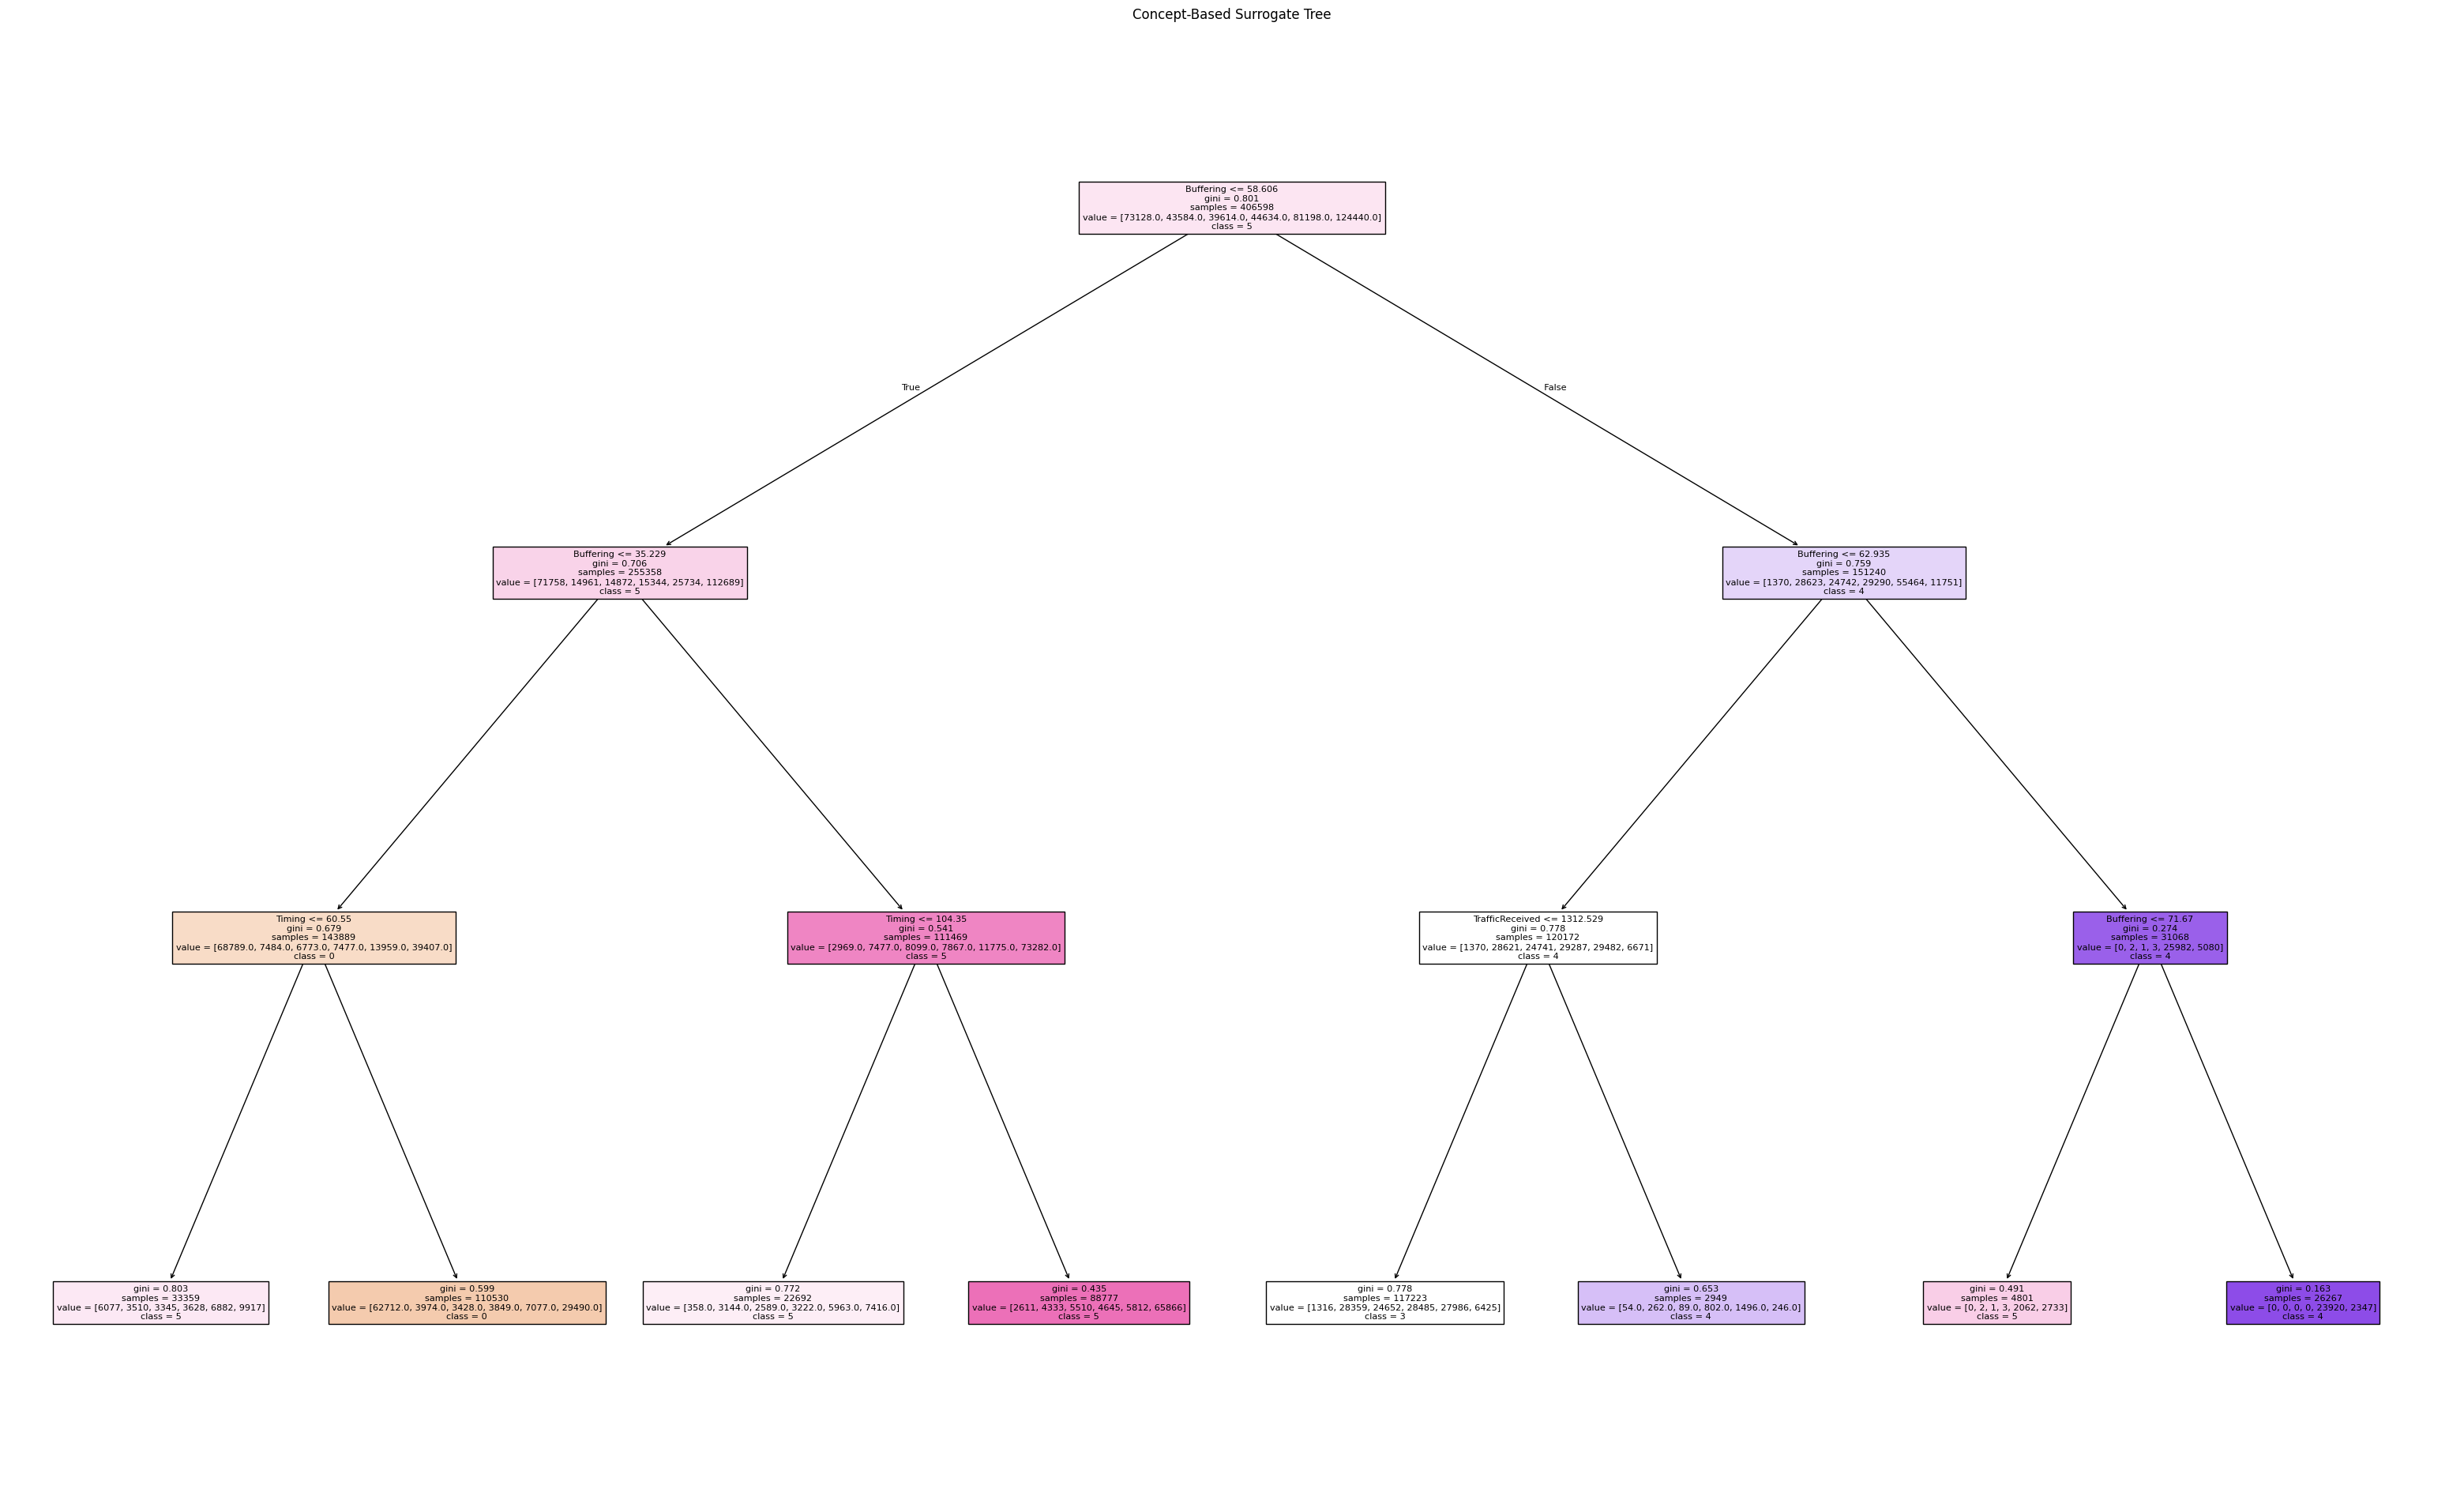

In [32]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Train a small decision tree on concept features
surrogate = DecisionTreeClassifier(max_depth=3, random_state=0)
surrogate.fit(X_test_concepts, y_test)

# Visualize the surrogate tree
plt.figure(figsize=(40, 24))
plot_tree(surrogate, 
          feature_names=X_test_concepts.columns, 
          filled=True, 
          class_names=[str(cls) for cls in sorted(y_test.unique())])
plt.title("Concept-Based Surrogate Tree")
plt.show()

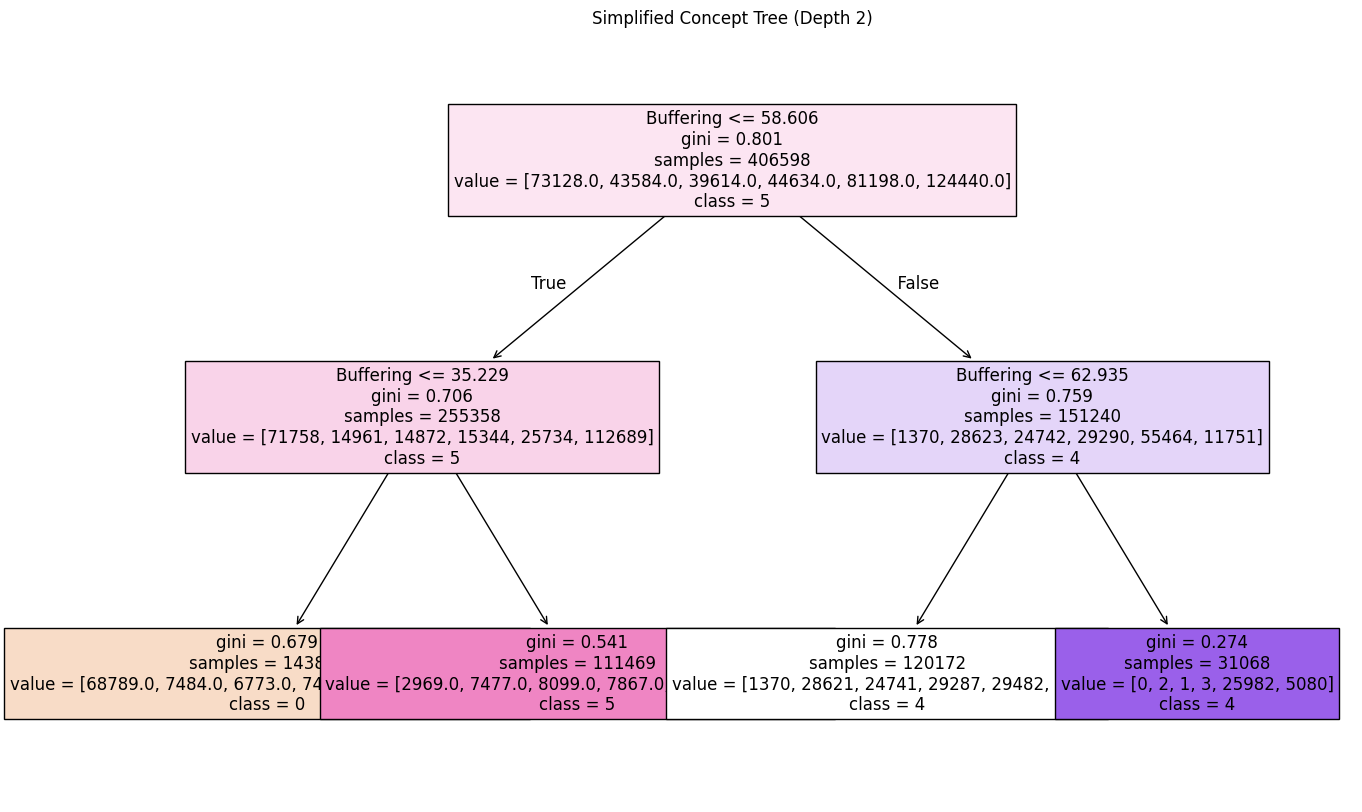

In [33]:
simpler_tree = DecisionTreeClassifier(max_depth=2, random_state=0)
simpler_tree.fit(X_test_concepts, y_test)

plt.figure(figsize=(16, 10))
plot_tree(
    simpler_tree,
    feature_names=X_test_concepts.columns,
    filled=True,
    class_names=[str(cls) for cls in sorted(y_test.unique())],
    fontsize=12
)
plt.title("Simplified Concept Tree (Depth 2)")
plt.show()

In [ ]:
import shap

# Sample and DataFrame
X_sample = X_train[:1000]
X_sample_df = pd.DataFrame(X_sample, columns=[
    'BufferHealth', 'RelativeTime', 'PlaybackProgress', 'BufferProgress', 'Length',
    'BytesSent', 'PacketsSent0', 'BytesSent0', 'PacketsReceived0', 'PacketsSent',
    'BytesReceived', 'PacketsReceived', 'BytesReceived0', 'BytesReceived25',
    'PacketsReceived25', 'BytesReceived1', 'BytesSent1', 'BytesSent25',
    'PacketsReceived1', 'PacketsSent1'
])
# X_sample_df = pd.DataFrame(X_sample, columns=[
#     'BufferHealth', 'RelativeTime', 'PlaybackProgress', 'BufferProgress', 'Length'
# ])

# Create SHAP explainer
explainer = shap.Explainer(clf.predict_proba, X_sample_df)
shap_values = explainer(X_sample_df)

# Summary plot for class index 0
shap.summary_plot(shap_values.values[:, :, 0], X_sample_df)